In [1]:
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/RotationCurveFit.py
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/ChainTool.py

import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import TFCube

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool
from Gamma import Gamma

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/branch_runs/tfCube2/../../../../KLens


# setup parameters

In [2]:
###### set up parameters ######
pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.25

pars['aspect'] = 0.2
pars['half_light_radius'] = 0.5
pars['theta_int'] = 0./180.*np.pi #np.pi/3.


pars['slitWidth'] = 1.0
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 6000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=pars['g1'])
theta_obs = cal_theta_obs(g1=pars['g1'], g2=pars['g2'], theta_int=pars['theta_int'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])
#pars['slitAngles'] = np.array([slitAng_major_p])


###### find flux_norm ######

flux_norm = find_flux_norm(pars, R=1.5)
print("flux_norm", flux_norm)

avgFlux_per_pix = avgFlux_in_R_per_pix(pars, flux_norm=flux_norm, R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)


##############################
line_species='Halpha'

2.9999999999999994e-16 erg / (cm2 nm s)
eobs_thy: 0.23450413223140495
slitAng_major_p: 2.726310993906266
slitAng_minor_p: 92.72631099390625
flux_norm 516.3410186767578
avgFlux_per_pix 0.9999999379724022


## setup slitAngles to major \& minor axes

In [3]:
###### image ######
GalIM = GalaxyImage(pars=pars, flux_norm=flux_norm)
obsImg, obsImgVariance = GalIM.observation(signal_to_noise=100.)

e_obs = GalIM.distorsion_int
modelImg = GalIM.model(e=e_obs, half_light_radius=pars['half_light_radius'], theta_int=pars['theta_int'], \
                       g1=pars['g1'], g2=pars['g2'])

###### spectra ######
TF = TFCube(pars=pars, line_species=line_species, flux_norm=flux_norm, sky_norm=1.)

modelSpec = TF.model2D(vcirc=TF.Pars.fid['vcirc'], sini=TF.Pars.fid['sini'], \
                       g1=TF.Pars.fid['g1'], g2=TF.Pars.fid['g2'], vscale=TF.Pars.fid['vscale'], \
                       v_0=TF.Pars.fid['v_0'], r_0=TF.Pars.fid['r_0'], theta_int=TF.Pars.fid['theta_int'], \
                       slitAngles=TF.Pars.fid['slitAngles'])

# obsCube = TF.observation3D()
# obsSpec = TF.observation2D(obsCube=obsCube)

###### prepare data_info ######

data_info = {'spec':modelSpec, 
             'image':modelImg,    
             'image_variance': obsImgVariance,
             'spec_variance': TF.skySpec,
             'par_fid': TF.Pars.fid,
             'flux_norm': flux_norm}

# data_info = {'spec':obsSpec, 
#              'image':obsImg,    
#              'image_variance': obsImgVariance,
#              'spec_variance': TF.skySpec}

data_info['lambdaGrid'] = TF.lambdaGrid
data_info['spaceGrid'] = TF.spaceGrid
data_info['line_species'] = line_species
data_info['lambda_emit'] = pars['linelist']['lambda'][pars['linelist']['species']==line_species][0] #656.461 # Halpha [nm]

print('line_species',line_species)
print('lambda_emit',data_info['lambda_emit'])

line_species Halpha
lambda_emit 656.461


In [4]:
# GM=Gamma(data_info=data_info, 
#          active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'half_light_radius'], #, 'theta_int'
#          par_fix = {'theta_int': 0.}
#         )

GM=Gamma(data_info=data_info, \
         active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'half_light_radius','theta_int'])

time cost in gaussFit_spec2D: 0.09496903419494629 (secs)
time cost in gaussFit_spec2D: 0.08342909812927246 (secs)


In [5]:
active_par_test = np.zeros(len(GM.active_par_key))
for j, item in enumerate(GM.active_par_key):
    active_par_test[j] = GM.par_fid[item]
active_par_test

array([2.e+02, 5.e-01, 5.e-01, 0.e+00, 0.e+00, 5.e-02, 5.e-02, 5.e-01,
       0.e+00])

In [6]:
GM.cal_loglike(active_par=active_par_test)

-0.091124934009409

In [7]:
chain_info = GM.run_MCMC(Nwalker=100, Nsteps=3000)

100%|██████████| 3000/3000 [06:10<00:00,  8.09it/s]

Total MCMC time (mins): 6.180745402971904


In [8]:
g1=pars['g1']
g2=pars['g2']
sini=pars['sini']
redshift=pars['redshift']
theta_int_deg=pars['theta_int']*180./np.pi

dir_save = '/Users/hhg/Research/kinematic_lensing/data/chainKLlike/chain_binnedFit_vs_tfCube2/'

fname_save = f'chainBinnedFit_Ha_2spec_g1{g1:.2f}_g2{g2:.2f}_sini{sini:.1f}_z{redshift:.2f}_thetaINT{theta_int_deg:.1f}_128_300k.pkl'
print(fname_save)
save_pickle(filename=dir_save+fname_save, info=chain_info)

chainBinnedFit_Ha_2spec_g10.05_g20.05_sini0.5_z0.25_thetaINT0.0_128_300k.pkl


In [4]:
# dir_save = '/Users/hhg/Research/kinematic_lensing/data/chainKLlike/chain_binnedFit_vs_tfCube2/'

# g1=pars['g1']
# g2=pars['g2']
# sini=pars['sini']
# redshift=pars['redshift']

# fname_retrive = f'chainBinnedFit_Ha_2spec_g1{g1:.2f}_g2{g2:.2f}_sini{sini:.1f}_z{redshift:.2f}_128_300k.pkl'
# chain_info = load_pickle(dir_save+fname_retrive)

In [9]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

In [10]:
from chainconsumer import ChainConsumer
blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

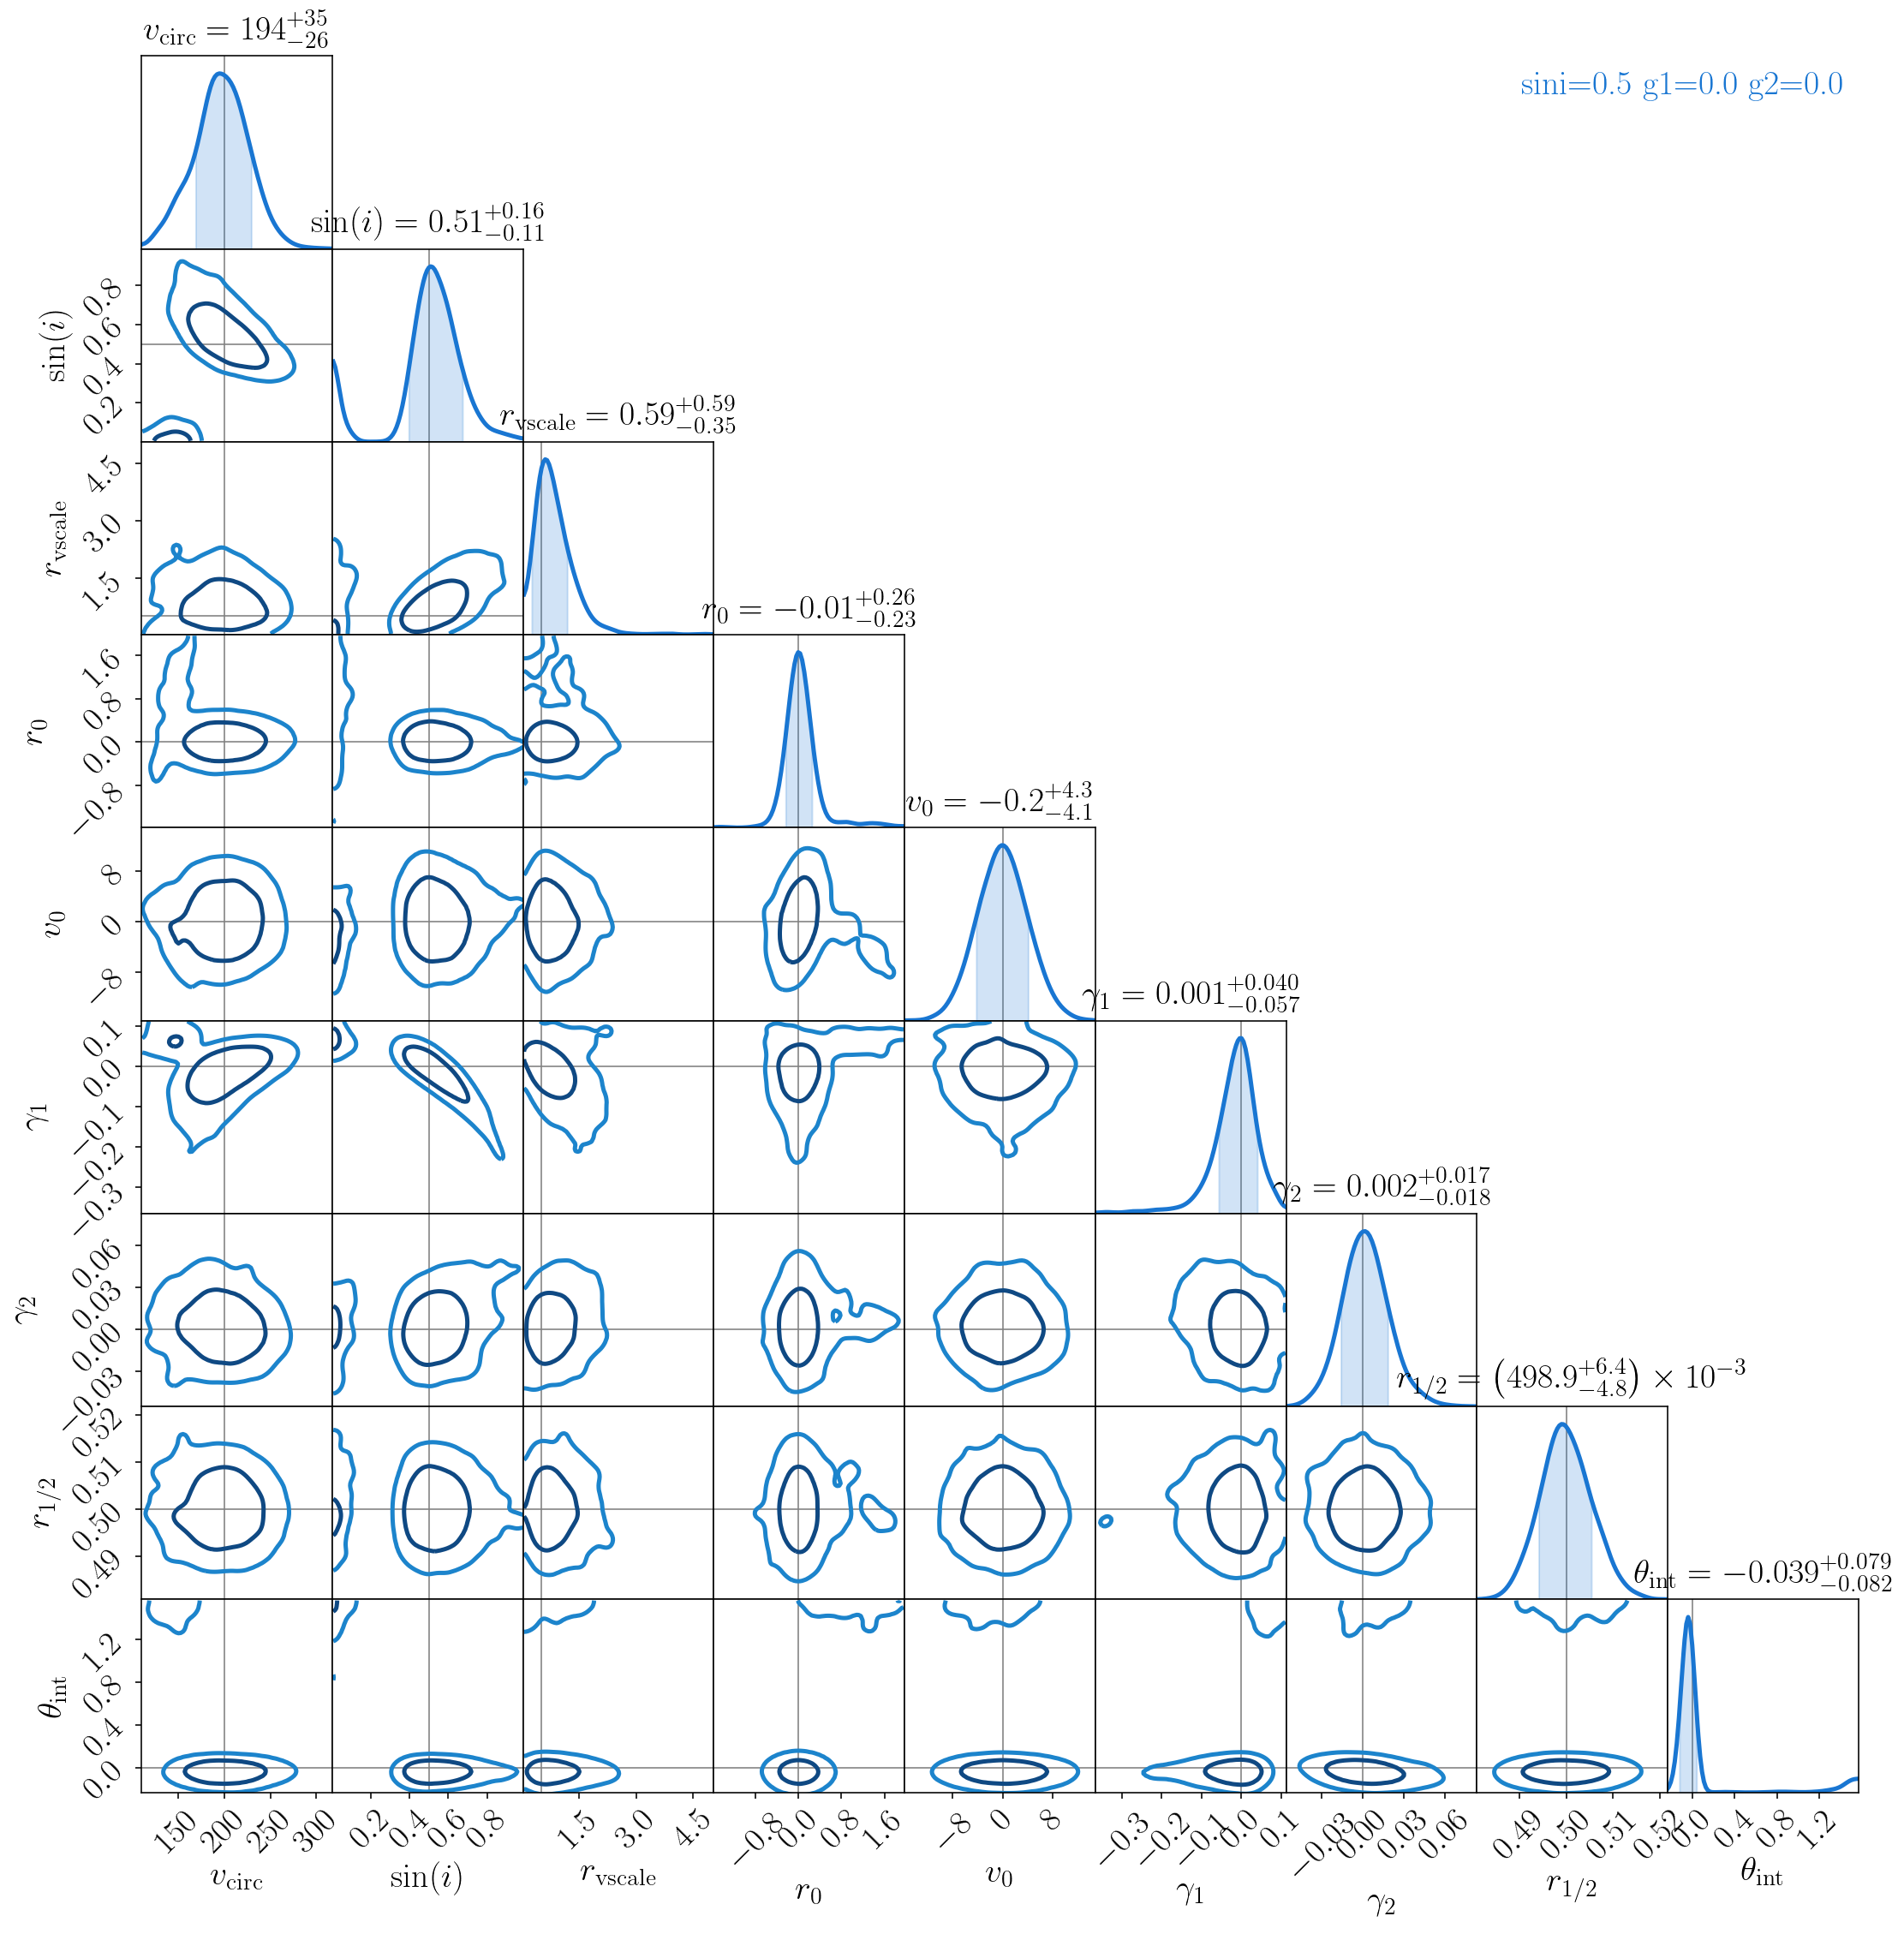

In [11]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = GM.active_par_key

#legend_chain = "sini=%.1f"%pars['sini']
g1=pars['g1']
g2=pars['g2']
sini=pars['sini']
legend_chain = f"sini={sini} g1={g1} g2={g2}"

parID1, parName1, par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1], parameters=parName1, name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20,
            shade=[False]*Nchains,
            statistics=statistics,summary=True)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig_all_pars.pdf", transparent=True)

In [40]:
par_bound={
    'sini':[0.,0.2]
}
subchain, sublnprob = Chain.extract_subchain(par_bound=par_bound)

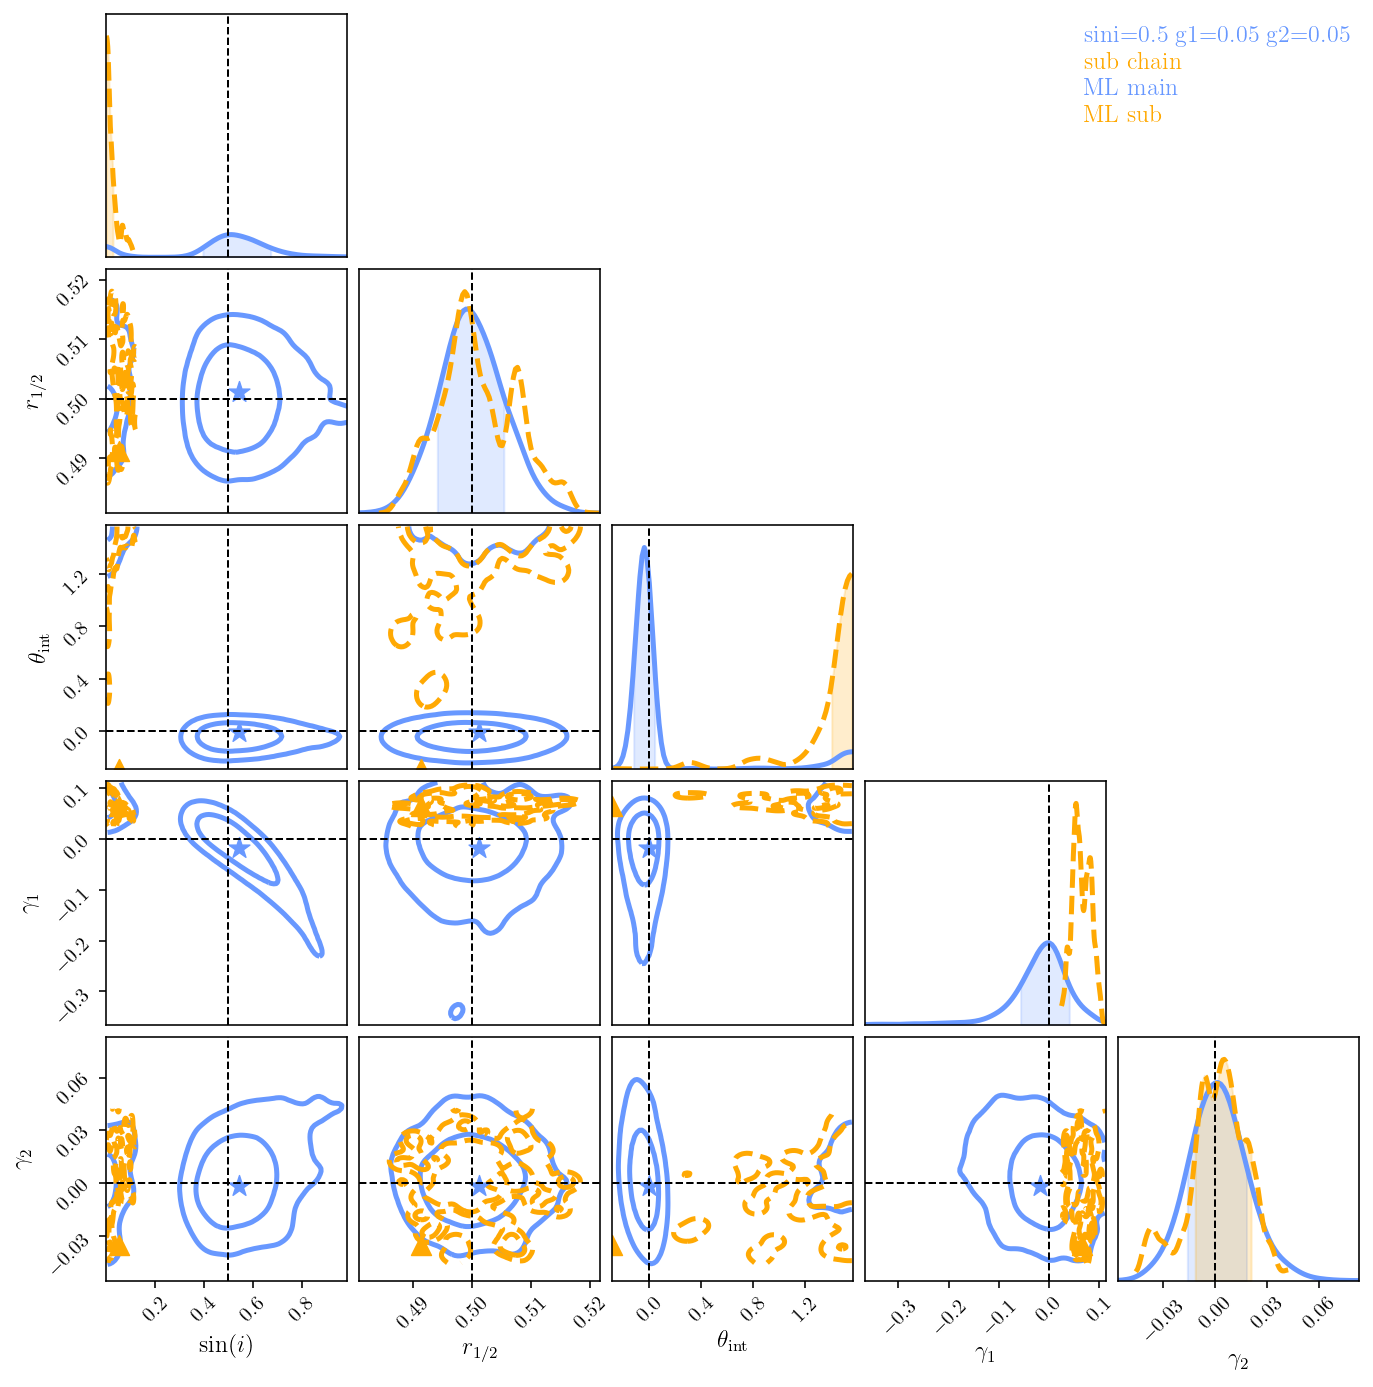

In [41]:
Nchains = 2
colors = [lightblue, yellow, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['sini', 'half_light_radius','theta_int','g1','g2']

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain)
c.add_chain(subchain[:, parID1]       , parameters=parName1 ,name='sub chain')

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=30,tick_font_size=30,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True)

MLmain, MLmain0 = Chain.par_maxlike()
c.add_marker(MLmain[parID1], parameters=parName1, marker_style='*', marker_size=120, color=lightblue, name='ML main')

MLsub, MLsub0 = Chain.par_maxlike(chain=subchain, lnprob=sublnprob)
c.add_marker(MLsub[parID1], parameters=parName1, marker_style='^', marker_size=100, color=yellow, name='ML sub')


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig_all_pars.pdf", transparent=True)

In [43]:
MLmain0

-0.23622513499818928

In [42]:
MLsub0

-95.55428393318289

In [44]:
MLmain

array([ 1.96536091e+02,  5.42463379e-01,  7.34027888e-01, -1.46131834e-02,
        5.50775993e-01, -1.77364315e-02, -1.66924452e-03,  5.01150147e-01,
       -2.67695927e-03])

In [45]:
MLsub

array([ 1.63769681e+02,  5.37676671e-02,  3.21615199e+00, -1.70149939e+00,
       -3.40816815e+00,  6.50624423e-02, -3.51905170e-02,  4.91313109e-01,
       -2.87115497e-01])

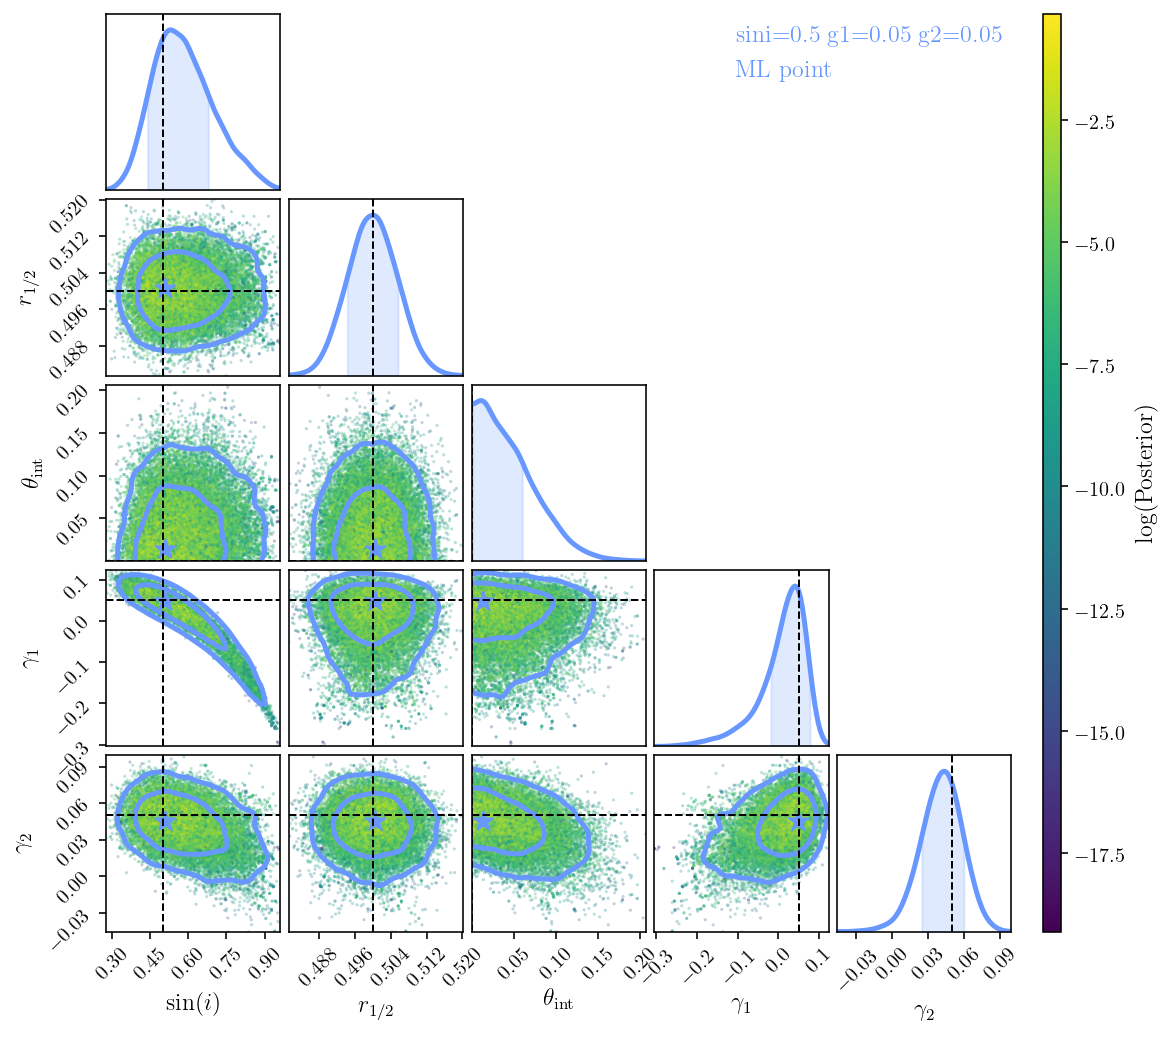

In [12]:
Nchains = 1
colors = [lightblue, yellow, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['sini', 'half_light_radius','theta_int','g1','g2']

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain, posterior=Chain.lnprob)
#c.add_chain(subchain[:, parID1]       , parameters=parName1 ,name='sub chain')

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=30,tick_font_size=30,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True,
            color_params='posterior')

MLmain, MLmain0 = Chain.par_maxlike()
c.add_marker(MLmain[parID1], parameters=parName1, marker_style='*', marker_size=120, color=lightblue, name='ML point')

#MLsub, MLsub0 = Chain.par_maxlike(chain=subchain, lnprob=sublnprob)
#c.add_marker(MLsub[parID1], parameters=parName1, marker_style='^', marker_size=100, color=yellow, name='ML sub')


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

#fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

#fig.set_size_inches(3.0 + fig.get_size_inches())
#fig.savefig("fig_all_pars.pdf", transparent=True)

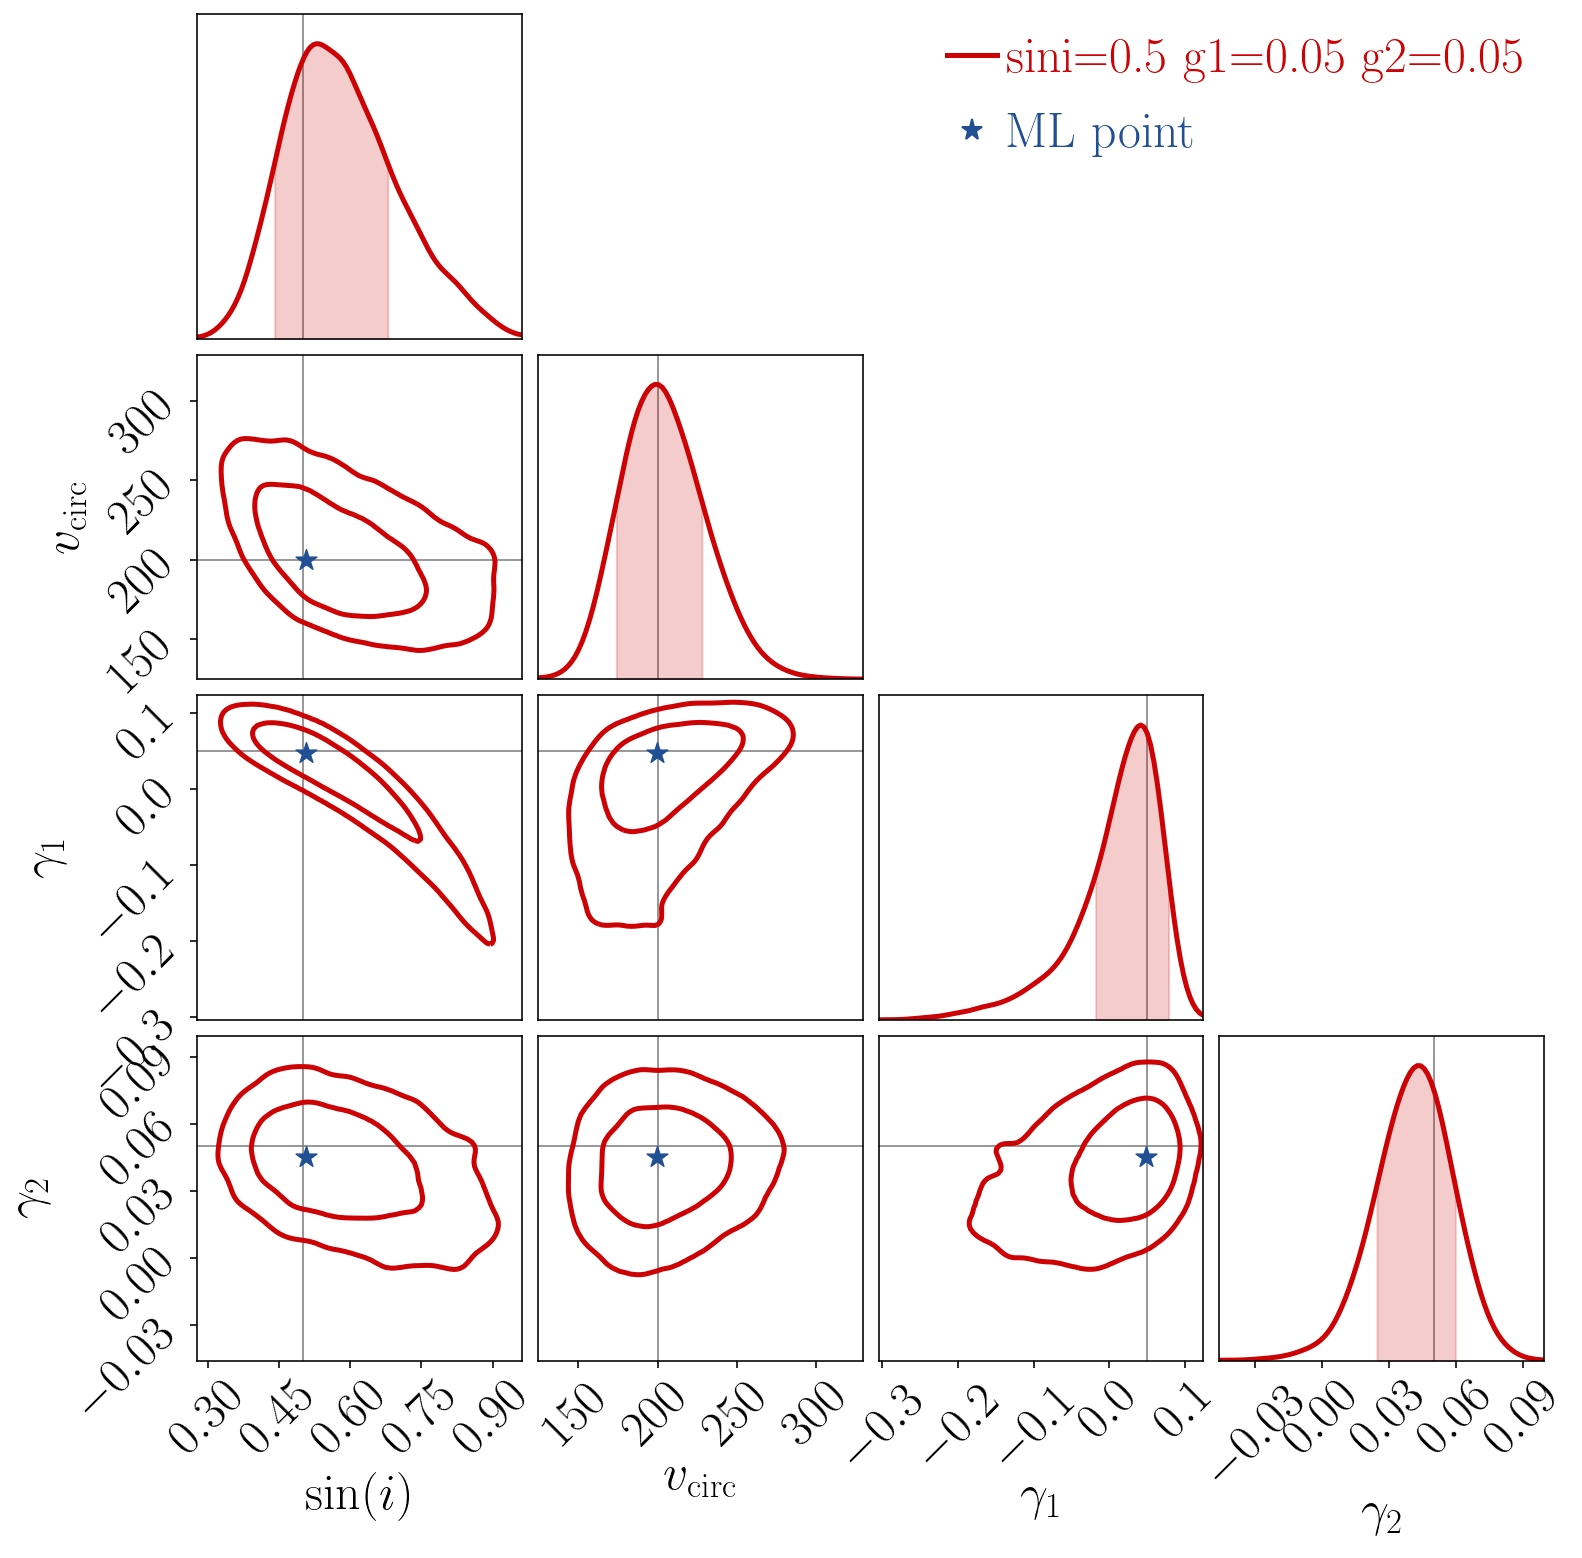

In [47]:
Nchains = 2
colors = [red, blue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['sini','vcirc','g1','g2']

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
#c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain, posterior=Chain.lnprob)
c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain)


#c.add_chain(subchain[:, parID1]       , parameters=parName1 ,name='sub chain')


MLmain, MLmain0 = Chain.par_maxlike()
c.add_marker(MLmain[parID1], parameters=parName1, marker_style='*', marker_size=120, name='ML point')


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=25,tick_font_size=25,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True) #,color_params='posterior'


#MLsub, MLsub0 = Chain.par_maxlike(chain=subchain, lnprob=sublnprob)
#c.add_marker(MLsub[parID1], parameters=parName1, marker_style='^', marker_size=100, color=yellow, name='ML sub')


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

#fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(5.0 + fig.get_size_inches())
#fig.savefig("fig_all_pars.pdf", transparent=True)

In [17]:
Chain.chain.shape

(150000, 9)

In [20]:
Chain.lnprob.shape

(150000,)

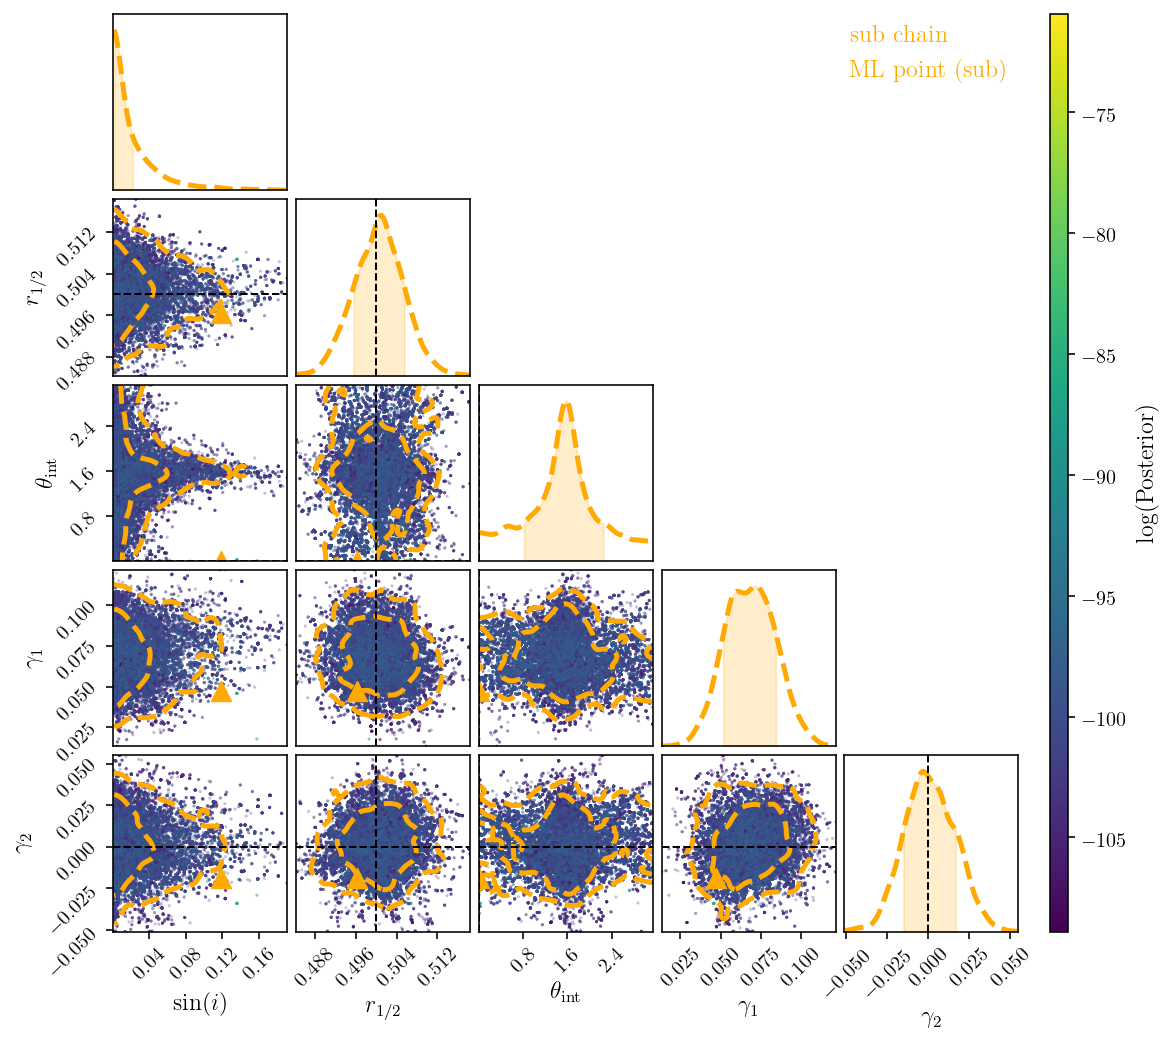

In [17]:
par_bound={
    'sini':[0.,0.2]
}
subchain, sublnprob = Chain.extract_subchain(par_bound=par_bound)

Nchains = 1
colors = [yellow, yellow, red, yellow, blue, yellowgreen, green, green, black]
lines = ["--", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['sini', 'half_light_radius','theta_int','g1','g2']

legend_chain = f"sini={pars['sini']} g1={pars['g1']} g2={pars['g2']}"


parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
#c.add_chain(Chain.chain[:, parID1]    , parameters=parName1 ,name=legend_chain, posterior=Chain.lnprob)
c.add_chain(subchain[:, parID1]       , parameters=parName1 ,name='sub chain', posterior=sublnprob)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=30,tick_font_size=30,
            shade=[False]*Nchains,
            colors=colors,
            linestyles=lines,
            statistics=statistics,
            shade_gradient=[0]*Nchains,
            summary=True,
            color_params='posterior')

#MLmain, MLmain0 = Chain.par_maxlike()
#c.add_marker(MLmain[parID1], parameters=parName1, marker_style='*', marker_size=120, color=lightblue, name='ML point')

MLsub, MLsub0 = Chain.par_maxlike(chain=subchain, lnprob=sublnprob)
c.add_marker(MLsub[parID1], parameters=parName1, marker_style='^', marker_size=100, color=yellow, name='ML point (sub)')


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

#fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

#fig.set_size_inches(3.0 + fig.get_size_inches())
#fig.savefig("fig_all_pars.pdf", transparent=True)